## Assignment II 
### Fixed-Length Decision Tree 

### Ashika Prakash Acharya (axa190084) 

## Problem: 
### Implement a fixed-depth decision tree algorithm, that is, the input to the ID3 algorithm will include the training data and maximum depth of the tree to be learned. The code skeleton as well as data sets for this assignment can be found on e-Learning.

#### a. (Autograder Score, 20 points) 
#### Your code will be auto-graded and cross-checked with other submissions. The auto-grader will evaluate your code on several different data sets to perform a sanity check. In order to ensure that your code passes the auto-grader, ensure that you do not modify the function headers. In addition, do not hard code any values (such as y = 0 and 1) and make your code as general as possible.

In [68]:
# decision_tree.py
# ---------
# Licensing Information:  You are free to use or extend these projects for
# personal and educational purposes provided that (1) you do not distribute
# or publish solutions, (2) you retain this notice, and (3) you provide clear
# attribution to UT Dallas, including a link to http://cs.utdallas.edu.
#
# This file is part of Homework for CS6375: Machine Learning.
# Gautam Kunapuli (gautam.kunapuli@utdallas.edu) jhnbv
# Sriraam Natarajan (sriraam.natarajan@utdallas.edu), 
# Anjum Chida (anjum.chida@utdallas.edu)
#
#
# INSTRUCTIONS:
# ------------
# 1. This file contains a skeleton for implementing the ID3 algorithm for
# Decision Trees. Insert your code into the various functions that have the
# comment "INSERT YOUR CODE HERE".
#
# 2. Do NOT modify the classes or functions that have the comment "DO NOT
# MODIFY THIS FUNCTION".
#
# 3. Do not modify the function headers for ANY of the functions.
#
# 4. You may add any other helper functions you feel you may need to print,
# visualize, test, or save the data and results. However, you MAY NOT utilize
# the package scikit-learn OR ANY OTHER machine learning package in THIS file.

In [140]:
import numpy as np
import statistics as stats
import os
import graphviz
import collections
import operator

In [3]:
def getAttributeValuePairs(x, n):
    """
    Return list of AttributeValue Pairs in the below format
    [(x1, a),
     (x1, b),
     (x1, c),
     (x2, d),
     (x2, e)]
    """
    pairs = []
    for i in range(0, n):
        values = np.unique(x[:, i])
        for value in values:
            tuple = (i+1, value)
            pairs.append(tuple)
    return pairs  

In [4]:
def partition(x):
    """
    Partition the column vector x into subsets indexed by its unique values (v1, ... vk)

    Returns a dictionary of the form
    { v1: indices of x == v1,
      v2: indices of x == v2,
      ...
      vk: indices of x == vk }, where [v1, ... vk] are all the unique values in the vector z.
    """
    
    unique = np.unique(x)
    dict = {key: [] for key in unique}
    for i in range(0, np.size(x, 0)):
        index = dict[x[i]]
        index.append(i)
        dict[x[i]] = index   
    return dict

In [5]:
def entropy(y):
    """
    Compute the entropy of a vector y by considering the counts of the unique values (v1, ... vk), in z

    Returns the entropy of z: H(z) = p(z=v1) log2(p(z=v1)) + ... + p(z=vk) log2(p(z=vk))
    """
    
    counter = collections.Counter(y)
    total = 0
    entropy = 0
    for i in counter:
        total += counter[i]
    for i in counter:    
        entropy += counter[i]/total * np.log2(counter[i]/total)
    return -entropy

In [6]:
def mutual_information(x, y):
    """
    Compute the mutual information between a data column (x) and the labels (y). The data column is a single attribute
    over all the examples (n x 1). Mutual information is the difference between the entropy BEFORE the split set, and
    the weighted-average entropy of EACH possible split.

    Returns the mutual information: I(x, y) = H(y) - H(y | x)
    """
    
    dict = {}
    S = entropy(y)
    subsets = partition(x)
    split_value = 0
    y_len = np.size(y, 0)
    for set in subsets:
        indices = subsets[set]
        if len(indices) != y_len:
            split_value = (len(indices) / y_len * entropy(y[indices])) + ((y_len - len(indices)) / y_len * entropy(np.delete(y, indices)))      
            MI = S - split_value
            dict[set] = MI
        else:
            dict[set] = 0
    return dict

In [159]:
 def id3(x, y, attribute_value_pairs=None, depth=0, max_depth=5):
    """
    Implements the classical ID3 algorithm given training data (x), training labels (y) and an array of
    attribute-value pairs to consider. This is a recursive algorithm that depends on three termination conditions
        1. If the entire set of labels (y) is pure (all y = only 0 or only 1), then return that label
        2. If the set of attribute-value pairs is empty (there is nothing to split on), then return the most common
           value of y (majority label)
        3. If the max_depth is reached (pre-pruning bias), then return the most common value of y (majority label)
    Otherwise the algorithm selects the next best attribute-value pair using INFORMATION GAIN as the splitting criterion
    and partitions the data set based on the values of that attribute before the next recursive call to ID3.

    The tree we learn is a BINARY tree, which means that every node has only two branches. The splitting criterion has
    to be chosen from among all possible attribute-value pairs. That is, for a problem with two features/attributes x1
    (taking values a, b, c) and x2 (taking values d, e), the initial attribute value pair list is a list of all pairs of
    attributes with their corresponding values:
    [(x1, a),
     (x1, b),
     (x1, c),
     (x2, d),
     (x2, e)]
     If we select (x2, d) as the best attribute-value pair, then the new decision node becomes: [ (x2 == d)? ] and
     the attribute-value pair (x2, d) is removed from the list of attribute_value_pairs.

    The tree is stored as a nested dictionary, where each entry is of the form
                    (attribute_index, attribute_value, True/False): subtree
    * The (attribute_index, attribute_value) determines the splitting criterion of the current node. For example, (4, 2)
    indicates that we test if (x4 == 2) at the current node.
    * The subtree itself can be nested dictionary, or a single label (leaf node).
    * Leaf nodes are (majority) class labels

    Returns a decision tree represented as a nested dictionary, for example
    {(4, 1, False):
        {(0, 1, False):
            {(1, 1, False): 1,
             (1, 1, True): 0},
         (0, 1, True):
            {(1, 1, False): 0,
             (1, 1, True): 1}},
     (4, 1, True): 1}
    """
    
    feature_count = np.size(x, 1)
    attribute_value_pairs = getAttributeValuePairs(x, feature_count)
    
    if depth == max_depth or len(attribute_value_pairs) == 0 or entropy(y) == 0:
        rep = collections.Counter(y)
        return rep.most_common(1)[0][0]
    
    info_gain = {}
    for key, value in attribute_value_pairs: 
        gain = (key, value)
        mi = mutual_information(x[:, key-1], y)
        if value in mi:
            info_gain[gain] = mi[value]
        else:
            info_gain[gain] = 0
    
    splitter = max(info_gain, key=info_gain.get)
    attribute_value_pairs.remove(splitter)
    
    tree = {}
    col = int(splitter[0]) - 1
    value = int(splitter[1])
    
    indices = partition(x[:, col])
    
    tree[splitter + (True, )] = id3(x[indices[value]], y[indices[value]], attribute_value_pairs, depth+1, max_depth)

    tree[splitter + (False, )] = id3(np.delete(x, indices[value], 0), np.delete(y, indices[value]), attribute_value_pairs, depth+1, max_depth)

    return tree
    

In [8]:
def pretty_print(tree, depth=0):
    """
    Pretty prints the decision tree to the console. Use print(tree) to print the raw nested dictionary representation
    DO NOT MODIFY THIS FUNCTION!
    """
    
    if depth == 0:
        print('TREE')

    for index, split_criterion in enumerate(tree):
        sub_trees = tree[split_criterion]

        # Print the current node: split criterion
        print('|\t' * depth, end='')
        print('+-- [SPLIT: x{0} = {1} {2}]'.format(split_criterion[0], split_criterion[1], split_criterion[2]))

        # Print the children
        if type(sub_trees) is dict:
            pretty_print(sub_trees, depth + 1)
        else:
            print('|\t' * (depth + 1), end='')
            print('+-- [LABEL = {0}]'.format(sub_trees))


In [9]:
def to_graphviz(tree, dot_string='', uid=-1, depth=0):
    """
    Converts a tree to DOT format for use with visualize/GraphViz
    DO NOT MODIFY THIS FUNCTION!
    """

    uid += 1       # Running index of node ids across recursion
    node_id = uid  # Node id of this node

    if depth == 0:
        dot_string += 'digraph TREE {\n'

    for split_criterion in tree:
        sub_trees = tree[split_criterion]
        attribute_index = split_criterion[0]
        attribute_value = split_criterion[1]
        split_decision = split_criterion[2]

        if not split_decision:
            # Alphabetically, False comes first
            dot_string += '    node{0} [label="x{1} = {2}?"];\n'.format(node_id, attribute_index, attribute_value)

        if type(sub_trees) is dict:
            if not split_decision:
                dot_string, right_child, uid = to_graphviz(sub_trees, dot_string=dot_string, uid=uid, depth=depth + 1)
                dot_string += '    node{0} -> node{1} [label="False"];\n'.format(node_id, right_child)
            else:
                dot_string, left_child, uid = to_graphviz(sub_trees, dot_string=dot_string, uid=uid, depth=depth + 1)
                dot_string += '    node{0} -> node{1} [label="True"];\n'.format(node_id, left_child)

        else:
            uid += 1
            dot_string += '    node{0} [label="y = {1}"];\n'.format(uid, sub_trees)
            if not split_decision:
                dot_string += '    node{0} -> node{1} [label="False"];\n'.format(node_id, uid)
            else:
                dot_string += '    node{0} -> node{1} [label="True"];\n'.format(node_id, uid)

    if depth == 0:
        dot_string += '}\n'
        return dot_string
    else:
        return dot_string, node_id, uid

In [10]:
def render_dot_file(dot_string, save_file, image_format='png'):
    """
    Uses GraphViz to render a dot file. The dot file can be generated using
        * sklearn.tree.export_graphviz()' for decision trees produced by scikit-learn
        * to_graphviz() (function is in this file) for decision trees produced by  your code.
    DO NOT MODIFY THIS FUNCTION!
    """
    
    if type(dot_string).__name__ != 'str':
        raise TypeError('visualize() requires a string representation of a decision tree.\nUse tree.export_graphviz()'
                        'for decision trees produced by scikit-learn and to_graphviz() for decision trees produced by'
                        'your code.\n')

    # Set path to your GraphViz executable here
    os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
    graph = graphviz.Source(dot_string)
    graph.format = image_format
    graph.render(save_file, view=True)
    

In [144]:
def predict_example(x, tree):
    """
    Predicts the classification label for a single example x using tree by recursively descending the tree until
    a label/leaf node is reached.

    Returns the predicted label of x according to tree
    """
    
    for k, v in tree.items():
        if x[k[0]-1] == k[1] and k[2] == True:
            if isinstance(v, dict):
                return predict_example(x, v)
            else:
                return v
        elif x[k[0]-1] != k[1] and k[2] == False:
            if isinstance(v, dict):
                return predict_example(x, v)
            else:
                return v      


In [12]:
def compute_error(y_true, y_pred):
    """
    Computes the average error between the true labels (y_true) and the predicted labels (y_pred)

    Returns the error = (1/n) * sum(y_true != y_pred)
    """
            
    return (sum(y_true != y_pred) * (1/len(y_true)))

    raise Exception('Function not yet implemented!')

In [209]:
if __name__ == '__main__':
    # Load the training data
    M = np.genfromtxt('./monks-1.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
    ytrn = M[:, 0]
    Xtrn = M[:, 1:]

    # Load the test data
    M = np.genfromtxt('./monks-1.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
    ytst = M[:, 0]
    Xtst = M[:, 1:]

    # Learn a decision tree of depth 3
    
    decision_tree = id3(Xtrn, ytrn, max_depth=3)

    # Pretty print it to console
    pretty_print(decision_tree)

    # Visualize the tree and save it as a PNG image
    dot_str = to_graphviz(decision_tree)
    render_dot_file(dot_str, './my_learned_tree')

    # Compute the test error
    y_pred = [predict_example(x, decision_tree) for x in Xtst]
    tst_err = compute_error(ytst, y_pred)

    print('Test Error = {0:4.2f}%.'.format(tst_err * 100))

TREE
+-- [SPLIT: x5 = 1 True]
|	+-- [LABEL = 1]
+-- [SPLIT: x5 = 1 False]
|	+-- [SPLIT: x1 = 1 True]
|	|	+-- [SPLIT: x2 = 1 True]
|	|	|	+-- [LABEL = 1]
|	|	+-- [SPLIT: x2 = 1 False]
|	|	|	+-- [LABEL = 0]
|	+-- [SPLIT: x1 = 1 False]
|	|	+-- [SPLIT: x2 = 1 True]
|	|	|	+-- [LABEL = 0]
|	|	+-- [SPLIT: x2 = 1 False]
|	|	|	+-- [LABEL = 1]
Test Error = 16.67%.


#### b. (Learning Curves, 20 points) 
#### For depth = 1, ..., 10, learn decision trees and compute the average training and test errors on each of the three MONK’s problems. Make three plots, one for each of the MONK’s problem sets, plotting training and testing error curves together for each problem, with tree depth on the x-axis and error on the y-axis.

In [223]:
if __name__ == '__main__':
    
    x_training_data = {}
    y_training_data = {}
    
    x_testing_data = {}
    y_testing_data = {}
    
    # Load the training data
    training_error = {}
    testing_error = {}
    
    for k in range(1,4):
        
        M = np.genfromtxt('./monks-'+str(k)+'.train', missing_values=0, skip_header=0, delimiter=',', dtype=int)
        y_training_data[k] = M[:, 0]
        x_training_data[k] = M[:, 1:]
            
        M = np.genfromtxt('./monks-'+str(k)+'.test', missing_values=0, skip_header=0, delimiter=',', dtype=int)
        y_testing_data[k] = M[:, 0]
        x_testing_data[k] = M[:, 1:]
        
        tr_error = {}
        te_error = {}
        
        for i in range(1,11):
            decision_tree = id3(x_training_data[k], y_training_data[k], max_depth=i)
            
            y_train_pred = [predict_example(x, decision_tree) for x in x_training_data[k]]
            tr_error[i] = round(compute_error(y_training_data[k], y_train_pred) * 100, 2)
            
            y_test_pred = [predict_example(x, decision_tree) for x in x_testing_data[k]]
            te_error[i] = round(compute_error(y_testing_data[k], y_test_pred) * 100, 2)
            
        
        training_error[k] = tr_error
        testing_error[k] = te_error
        
    for key in training_error:
        print("mean of training error for monks-", key, " dataset :: ", np.mean(list(training_error[key].values())))
    print("-----")
    for key in testing_error:
        print("mean of testing error for monks-", key, " dataset :: ", np.mean(list(testing_error[key].values())))

mean of training error for monks- 1  dataset ::  9.111999999999998
mean of training error for monks- 2  dataset ::  16.924
mean of training error for monks- 3  dataset ::  4.673
-----
mean of testing error for monks- 1  dataset ::  14.538
mean of testing error for monks- 2  dataset ::  24.886000000000003
mean of testing error for monks- 3  dataset ::  9.308


[0, 11, 0, 50]

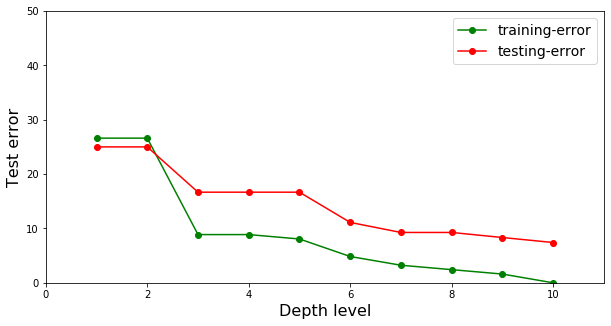

In [224]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(list(training_error[1].keys()), list(training_error[1].values()), marker='o', color='green')
plt.plot(list(testing_error[1].keys()), list(testing_error[1].values()), marker='o', color='red')

plt.legend(['training-error', 'testing-error'], fontsize=14)
plt.xlabel('Depth level', fontsize=16)
plt.ylabel('Test error', fontsize=16)
plt.axis([0, 11, 0, 50])

[0, 11, 0, 50]

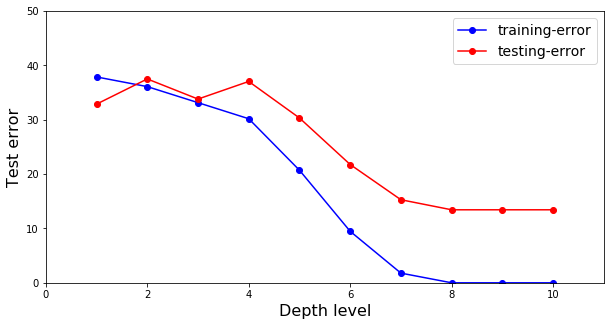

In [225]:
plt.figure(figsize=(10,5))
plt.plot(list(training_error[2].keys()), list(training_error[2].values()), marker='o', color='blue')
plt.plot(list(testing_error[2].keys()), list(testing_error[2].values()), marker='o', color='red')

plt.legend(['training-error', 'testing-error'], fontsize=14)
plt.xlabel('Depth level', fontsize=16)
plt.ylabel('Test error', fontsize=16)
plt.axis([0, 11, 0, 50])

[0, 11, 0, 50]

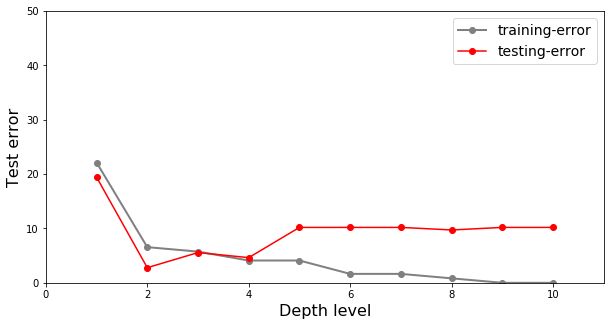

In [226]:
plt.figure(figsize=(10,5))
plt.plot(list(training_error[3].keys()), list(training_error[3].values()), marker='o', color='grey', linewidth=2)
plt.plot(list(testing_error[3].keys()), list(testing_error[3].values()), marker='o', color='red')

plt.legend(['training-error', 'testing-error'], fontsize=14)
plt.xlabel('Depth level', fontsize=16)
plt.ylabel('Test error', fontsize=16)
plt.axis([0, 11, 0, 50])

#### c. (Weak Learners, 20 points) 
#### For monks-1, report the visualized learned decision tree and the confusion matrix on the test set for depth = 1, 3, 5. You may use scikit-learns’s confusion matrix() function [2].

In [173]:
def plot_conf_matrix(cm):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + [0, 1])
    ax.set_yticklabels([''] + [0, 1])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Confusion Matrix for Monks-1 dataset with depth  1
[[216   0]
 [108 108]]


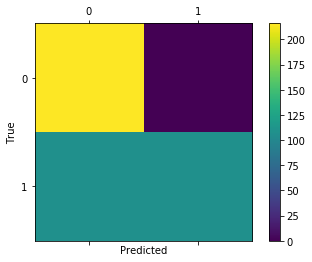

Confusion Matrix for Monks-1 dataset with depth  3
[[144  72]
 [  0 216]]


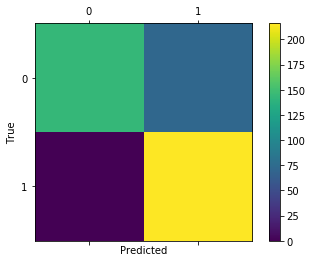

Confusion Matrix for Monks-1 dataset with depth  5
[[156  60]
 [ 12 204]]


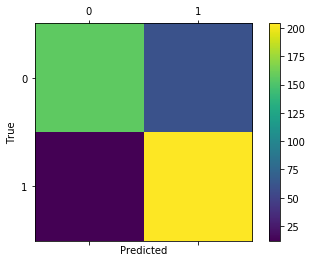

In [228]:
from sklearn.metrics import confusion_matrix

for depth in [1,3,5]:
    print("Confusion Matrix for Monks-1 dataset with depth ", depth)
    
    decision_tree = id3(x_training_data[1], y_training_data[1], max_depth=depth)
    
    dot_str = to_graphviz(decision_tree)
    file_name = './my_learned_tree_monks_1_depth_' + str(depth)
    render_dot_file(dot_str, file_name)
    
    y_pred = [predict_example(x, decision_tree) for x in x_testing_data[1]]
    
    cm = confusion_matrix(y_testing_data[1], y_pred, labels=[0, 1])
    print(cm)
    plot_conf_matrix(cm)
    
    print("=======================================================")
    

#### d. (scikit-learn, 20 points) 
#### For monks-1, use scikit-learn’s DecisionTreeClassifier [3] to learn a decision tree using criterion=’entropy’ for depth = 1, 3, 5. You may use scikit-learn’s confusion matrix() function [2].

Confusion Matrix for Monks-1 dataset with depth  1
[[216   0]
 [108 108]]


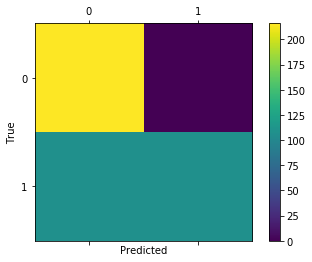

Confusion Matrix for Monks-1 dataset with depth  3
[[144  72]
 [  0 216]]


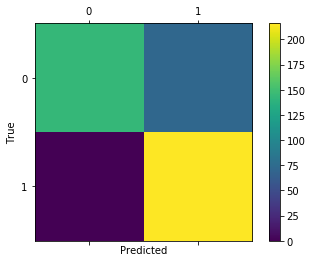

Confusion Matrix for Monks-1 dataset with depth  5
[[168  48]
 [ 24 192]]


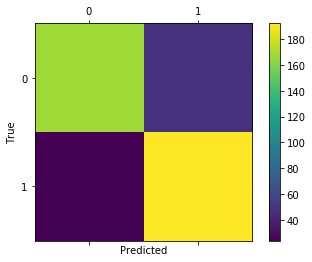

In [235]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

for depth in [1,3,5]:
    print("Confusion Matrix for Monks-1 dataset with depth ", depth)
    
    sk_tree = DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=depth)
    
    sk_tree = sk_tree.fit(x_training_data[1], y_training_data[1])
    file = './sk_tree' + str(depth)
    render_dot_file(export_graphviz(sk_tree), file)
    
    sk_y_pred = [sk_tree.predict(x.reshape(1, -1)) for x in x_testing_data[1]]
    
    cm2 = confusion_matrix(y_testing_data[1], sk_y_pred)
    print(cm2)
    
    plot_conf_matrix(cm2)
    print("=======================================================")
    

#### e. (Other Data Sets, 20 points) 
#### Repeat steps (c) and (d) with your “own” data set and report the confusion matrices. You can use other data sets in the UCI repository.

Confusion Matrix for SomerVilleHappiness Survey 2015 dataset with depth  1
[[ 0 24]
 [ 2 17]]


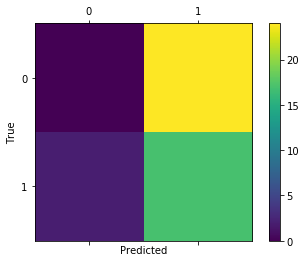

Confusion Matrix for SomerVilleHappiness Survey 2015 dataset with depth  3
[[ 3 21]
 [ 3 16]]


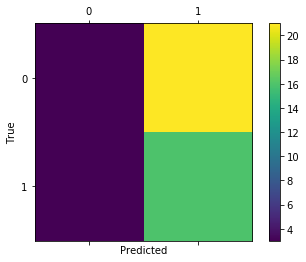

Confusion Matrix for SomerVilleHappiness Survey 2015 dataset with depth  5
[[ 3 21]
 [ 5 14]]


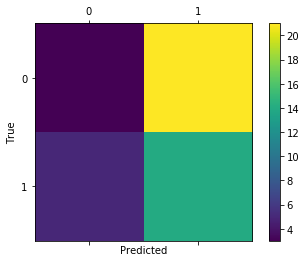

In [232]:
from sklearn.model_selection import train_test_split

M = np.genfromtxt('./SomervilleHappiness.csv', missing_values=0, skip_header=1, delimiter=',', dtype=int, encoding='utf16')

y_data = M[:, 0]
y_trn, y_tst = train_test_split(y_data, test_size=0.3, random_state=42)
x_data = M[:, 1:6]
x_trn, x_tst = train_test_split(x_data, test_size=0.3, random_state=42)

for depth in [1,3,5]:
    print("Confusion Matrix for SomerVilleHappiness Survey 2015 dataset with depth ", depth)

    decision_tree = id3(x_trn, y_trn, max_depth=depth)
    
    dot_str = to_graphviz(decision_tree)
    file_name = './SomervilleHappiness_depth_' + str(depth)
    render_dot_file(dot_str, file_name)
    
    y_pred = [predict_example(x, decision_tree) for x in x_tst]
    
    cm = confusion_matrix(y_tst, y_pred, labels=[0, 1])
    print(cm)
    plot_conf_matrix(cm)
    
    print("=======================================================")

Confusion Matrix for SomervilleHappiness Survey 2015 dataset with depth  1
[[ 0 24]
 [ 2 17]]


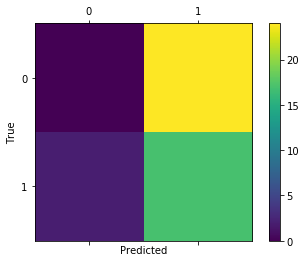

Confusion Matrix for SomervilleHappiness Survey 2015 dataset with depth  3
[[ 3 21]
 [ 4 15]]


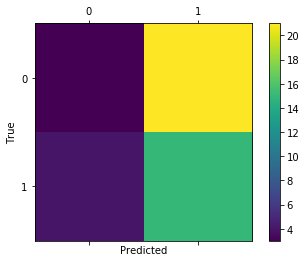

Confusion Matrix for SomervilleHappiness Survey 2015 dataset with depth  5
[[ 7 17]
 [ 5 14]]


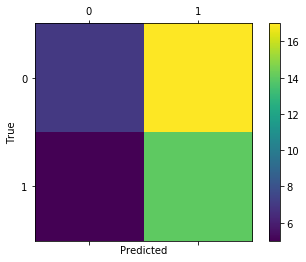

In [234]:
for depth in [1,3,5]:
    print("Confusion Matrix for SomervilleHappiness Survey 2015 dataset with depth ", depth)
    
    sk_tree = DecisionTreeClassifier(criterion="entropy", splitter="best", max_depth=depth)
    
    sk_tree = sk_tree.fit(x_trn, y_trn)
    file = './sk_tree' + str(depth)
    render_dot_file(export_graphviz(sk_tree), file)
    
    sk_y_pred = [sk_tree.predict(x.reshape(1, -1)) for x in x_tst]
    
    cm2 = confusion_matrix(y_tst, sk_y_pred)
    print(cm2)
    
    plot_conf_matrix(cm2)
    print("=======================================================")